<a href="https://colab.research.google.com/github/andyboat75/Energy-Efficient-Distributed-System/blob/main/home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# START



In [ ]:
! pip install pmdarima

## Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import date, datetime
import time

import math
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import warnings
warnings.filterwarnings('ignore')

## Accessing Data from Gdrive

In [ ]:
# Importing dataset from google drive and reading it
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

# DATA Cleaning and Exploratory Data Analysis

In [ ]:
df = pd.read_csv('HomeC.csv')
# df.head()

df.drop(index=len(df)-1, inplace=True) # the last row were all null

date_ls = df.time.apply(int)
df.time = date_ls.apply(datetime.fromtimestamp)    #turn the date column to a datetime object


# we are interested in energy consumption(KW) of the various appliances over time and not the wheather information.
df_column = [k for k in df.columns if 'kW' in k]
df_column.append('time')
df = df[df_column].copy()


# 'solar' column gives info on energy produced by solar and 'gen' is the total energy generated.
# 'House overall' is the same as the total energy consumed so we will drop all this columns
df.drop(['gen [kW]','House overall [kW]','Solar [kW]'],axis=1, inplace=True)


df.columns = ['total_energy_used','Dishwasher','Furnace 1','Furnace 2','Home office','Fridge','Wine cellar',
 'Garage door',
 'Kitchen 12',
 'Kitchen 14',
 'Kitchen 38',
 'Barn',
 'Well',
 'Microwave',
 'Living room','time']

target = 'total_energy_used'
features = [k for k in df.columns if k != target]
# features

In [ ]:
# checking the time interval which appears to be in 1 second as opposed to the 1 minutes said on the site
df['Time_interval'] = df.time - df.time.shift(1)
df[['time', 'Time_interval']].head()


,time,Time_interval
0,2016-01-01 05:00:00,NaT
1,2016-01-01 05:00:01,0 days 00:00:01
2,2016-01-01 05:00:02,0 days 00:00:01
3,2016-01-01 05:00:03,0 days 00:00:01
4,2016-01-01 05:00:04,0 days 00:00:01


In [ ]:
df.drop('Time_interval', inplace=True, axis=1)

In [ ]:
main_df = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503910 entries, 0 to 503909
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   total_energy_used  503910 non-null  float64       
 1   Dishwasher         503910 non-null  float64       
 2   Furnace 1          503910 non-null  float64       
 3   Furnace 2          503910 non-null  float64       
 4   Home office        503910 non-null  float64       
 5   Fridge             503910 non-null  float64       
 6   Wine cellar        503910 non-null  float64       
 7   Garage door        503910 non-null  float64       
 8   Kitchen 12         503910 non-null  float64       
 9   Kitchen 14         503910 non-null  float64       
 10  Kitchen 38         503910 non-null  float64       
 11  Barn               503910 non-null  float64       
 12  Well               503910 non-null  float64       
 13  Microwave          503910 non-null  float64 

In [ ]:
# check empty data points
main_df.isnull().sum()

total_energy_used    0
Dishwasher           0
Furnace 1            0
Furnace 2            0
Home office          0
Fridge               0
Wine cellar          0
Garage door          0
Kitchen 12           0
Kitchen 14           0
Kitchen 38           0
Barn                 0
Well                 0
Microwave            0
Living room          0
time                 0
dtype: int64

## EDA

In [ ]:
main_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_energy_used,503910.0,0.858962,1.058207,0.000000,0.367667,0.562333,0.970250,14.714567
Dishwasher,503910.0,0.031368,0.190951,0.000000,0.000000,0.000017,0.000233,1.401767
Furnace 1,503910.0,0.099210,0.169059,0.000017,0.020233,0.020617,0.068733,1.934083
Furnace 2,503910.0,0.136779,0.178631,0.000067,0.064400,0.066633,0.080633,0.794933
Home office,503910.0,0.081287,0.104466,0.000083,0.040383,0.042217,0.068283,0.971750
Fridge,503910.0,0.063556,0.076199,0.000067,0.005083,0.005433,0.125417,0.851267
Wine cellar,503910.0,0.042137,0.057967,0.000017,0.007133,0.008083,0.053192,1.273933
Garage door,503910.0,0.014139,0.014292,0.000017,0.012733,0.012933,0.013100,1.088983
Kitchen 12,503910.0,0.002755,0.021860,0.000000,0.000500,0.000667,0.000750,1.166583
Kitchen 14,503910.0,0.007023,0.076740,0.000000,0.000017,0.000050,0.000167,2.262583


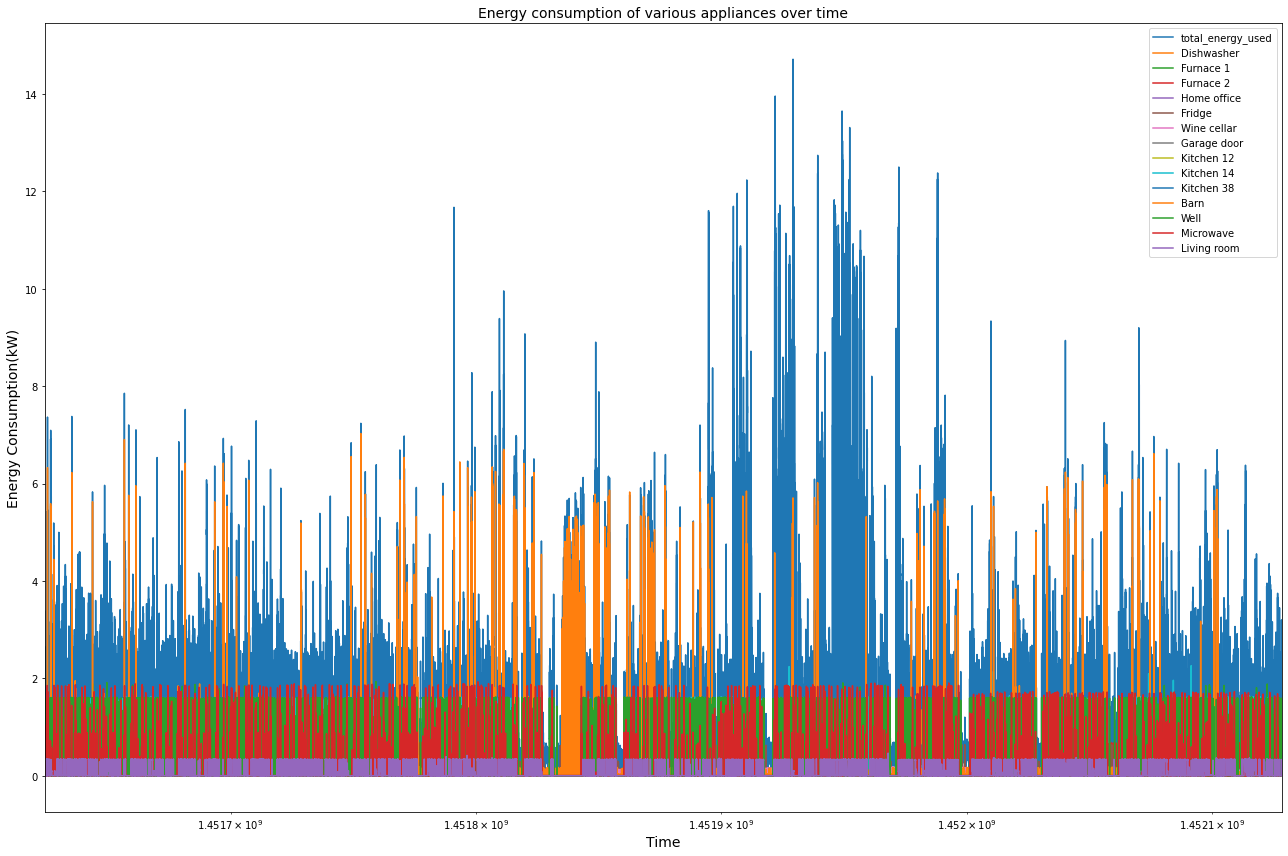

In [ ]:
main_df.set_index('time').plot(figsize=(18,12))
plt.xscale('log')
plt.title('Energy consumption of various appliances over time', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption(kW)', fontsize=14)
plt.tight_layout()
plt.show()

## Feature and Target plots
Plot of Some features over time

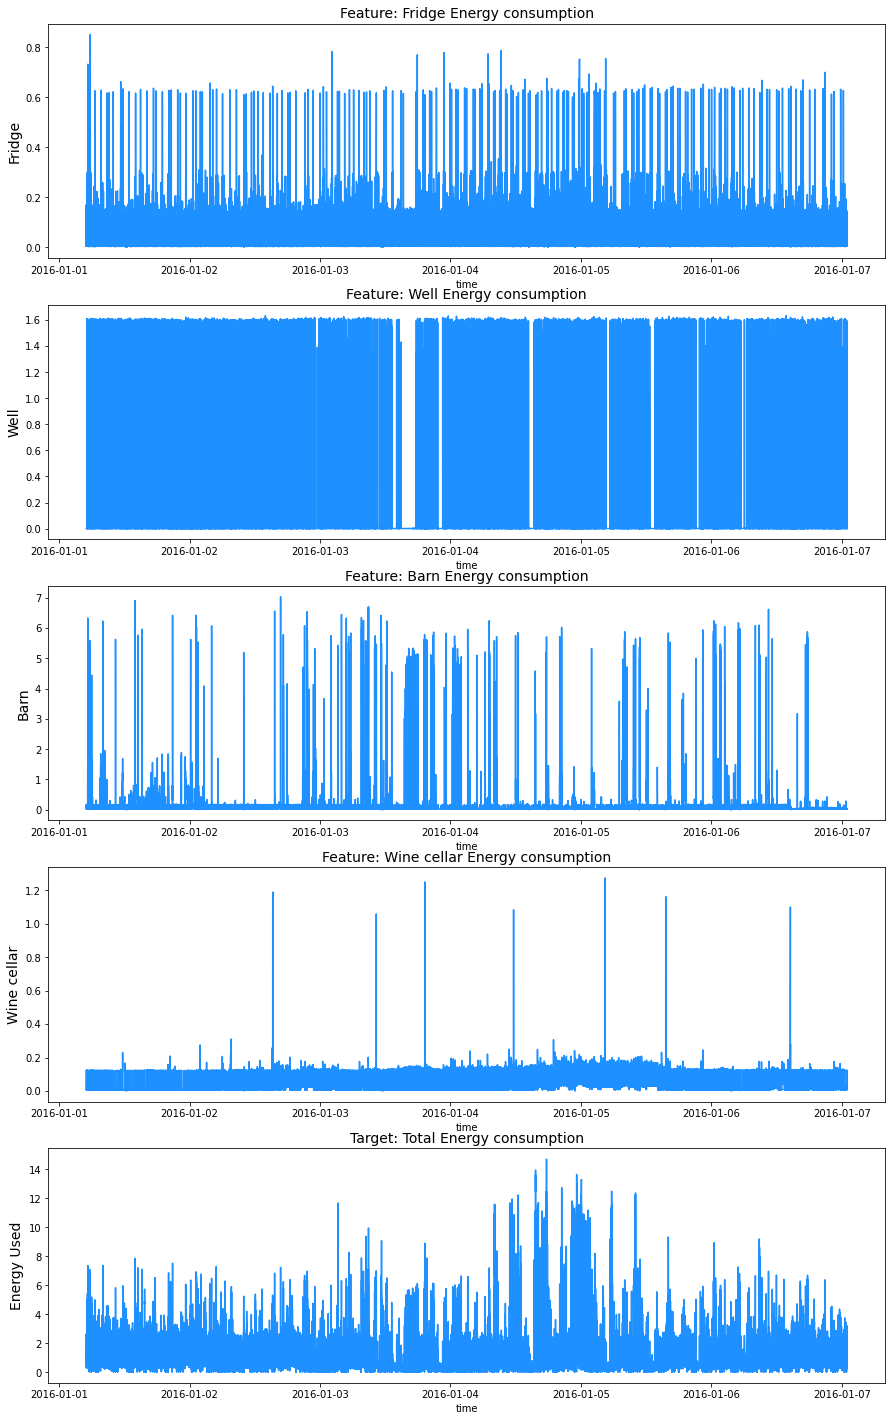

In [ ]:
# We randomly select any of features that contribute to energy consumption and plot it.
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15,25))
feature_plots = list()
for index,val in enumerate(random.sample(features[:-1],4)):
    feature_plots.append(val)
    sns.lineplot(x=main_df['time'], y= main_df[val], ax=ax[index], color='dodgerblue')
    ax[index].set_title(f'Feature: {val} Energy consumption', fontsize=14)
    ax[index].set_ylabel(f'{val}', fontsize=14)
    
    
sns.lineplot(x=main_df['time'], y= main_df[target], ax=ax[4], color='dodgerblue')
ax[4].set_title(f'Target: Total Energy consumption', fontsize=14)
ax[4].set_ylabel(f'Energy Used', fontsize=14)
feature_plots.append(target)

# Stationary or Non Stationary And Seasonality

In this section, we will perform various test to check the stationarity of our time series. Such test will include Augmented Dickey Fuller test, Resampling and Rolling of Data.

We will lastly, perform seasonality check by decomposing our time series.


## Rolling Test

From the results below you can see that our time series is relatively stationary.
That is the mean and standard deviation is almost constant over time.

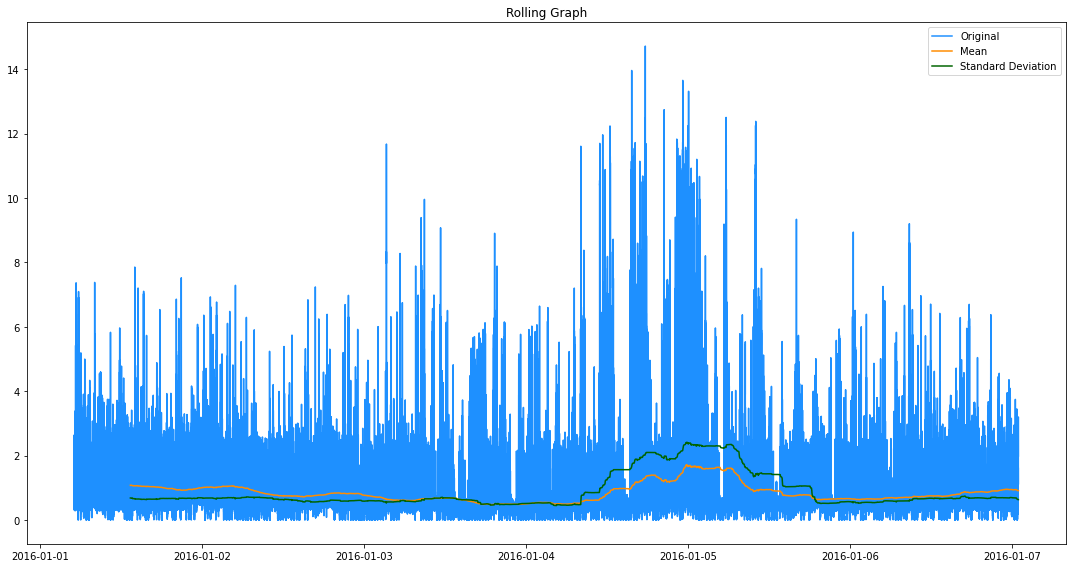

In [ ]:
rol_df = df.copy()
rol_df.set_index('time', inplace=True)
rol_mean = rol_df.rolling(window=30000).mean() #window size 500 minutes = 60s * 500
rol_std = rol_df.rolling(window=30000).std()


f, ax = plt.subplots(figsize=(15,8))
ax.plot(rol_df.index, rol_df[target], color='dodgerblue', label='Original')
ax.plot(rol_mean.index, rol_mean[target], color='darkorange', label='Mean')
ax.plot(rol_std.index, rol_std[target], color='darkgreen', label='Standard Deviation')
ax.set_title(f'Rolling Graph')
plt.tight_layout()
plt.legend()
plt.savefig('Rolling.png')
plt.show()

## Resampling & ADF Test
From the results below it is evidently clear that our data is stationary.

In [ ]:
res_df = df.copy()

In [ ]:
# simple sampling function
def sampler(data, samp_freq):
    # data['Timestamp'] = data['time']
    # data.index = data.Timestamp
    data.index=data.time
    data = data.resample(samp_freq).mean()
    return data

In [ ]:
# stationarity test function/ ADF test
def test_stationarity(data, target, samp_data):
    results = adfuller(data[target])
    # print(f"ACDF Statistics: {results[0]}")
    # print(f"p-value: {results[1]}")
    if results[1] > 0.05:
        print(f"{samp_data} sampled data: Non stationary")
        print(f"p-value: {results[1]}\n")
    else:
        print(f"{samp_data} sampled data: Stationary")
        print(f"p-value: {results[1]}\n")
    return results

=========ADF test results==========
A minute sampled data: Stationary
p-value: 3.470341146978128e-14

8399


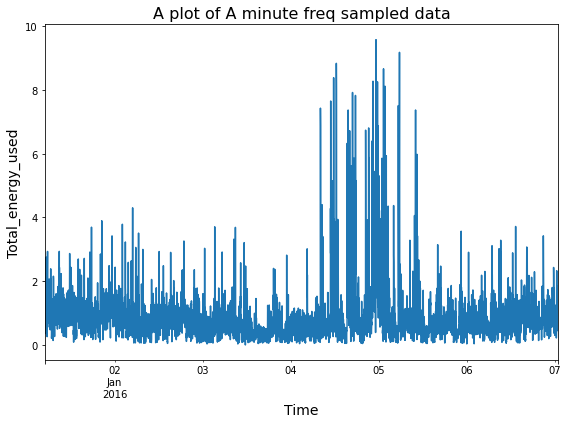

=========ADF test results==========
10 Minutes sampled data: Stationary
p-value: 0.0002097768223345841

840


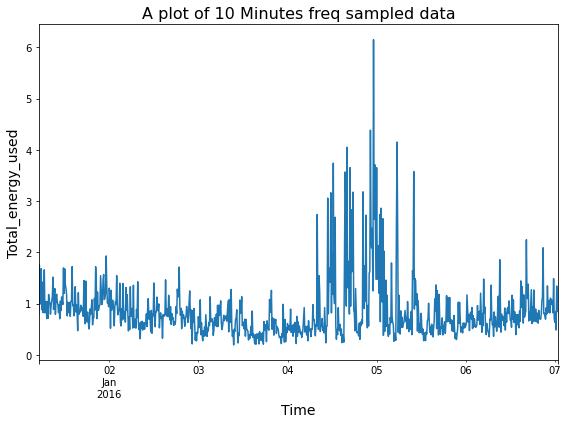

=========ADF test results==========
30 Minutes sampled data: Stationary
p-value: 2.6080521341125486e-10

280


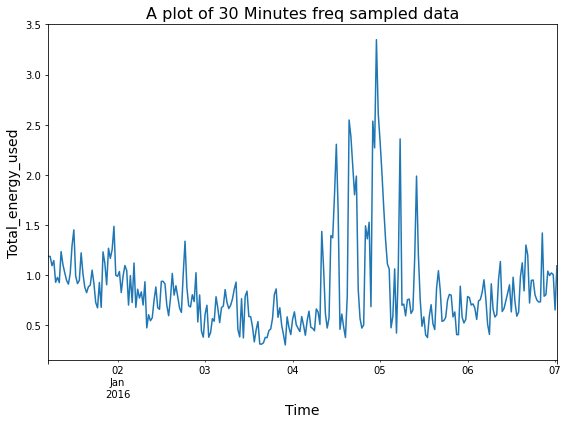

In [ ]:
# # fig, ax = plt.subplots(figsize=(8,6))
sample_freq_dict = {'60S':'A minute','600S':'10 Minutes','1800S':'30 Minutes'}
for i, freq in enumerate(sample_freq_dict.keys()):
    print("=========ADF test results==========")
    sampled_data = sampler(res_df, freq)
    adfc_test_results = test_stationarity(sampled_data, target=target, samp_data=sample_freq_dict[freq])
    sampled_data[target].plot(figsize=(8,6))
    print(len(sampled_data))
    plt.title(f'A plot of {sample_freq_dict[freq]} freq sampled data', fontsize=16)
    plt.ylabel(ylabel=target.capitalize(), fontsize=14)
    plt.xlabel(xlabel='Time', fontsize=14)
    plt.savefig(f'{sample_freq_dict[freq]}_resampled.png')
    # plt.legend()
    plt.tight_layout()
    plt.show()

ADF Test results

A minute sampled data: Stationary
p-value: 3.470341146978128e-14

8399
ADF Test results

10 Minutes sampled data: Stationary
p-value: 0.0002097768223345841

840
ADF Test results

30 Minutes sampled data: Stationary
p-value: 2.6080521341125486e-10

280
ADF Test results

1 hour sampled data: Non stationary
p-value: 0.061495449702854185

140
ADF Test results

2 hour sampled data: Non stationary
p-value: 0.1816865898443662

71


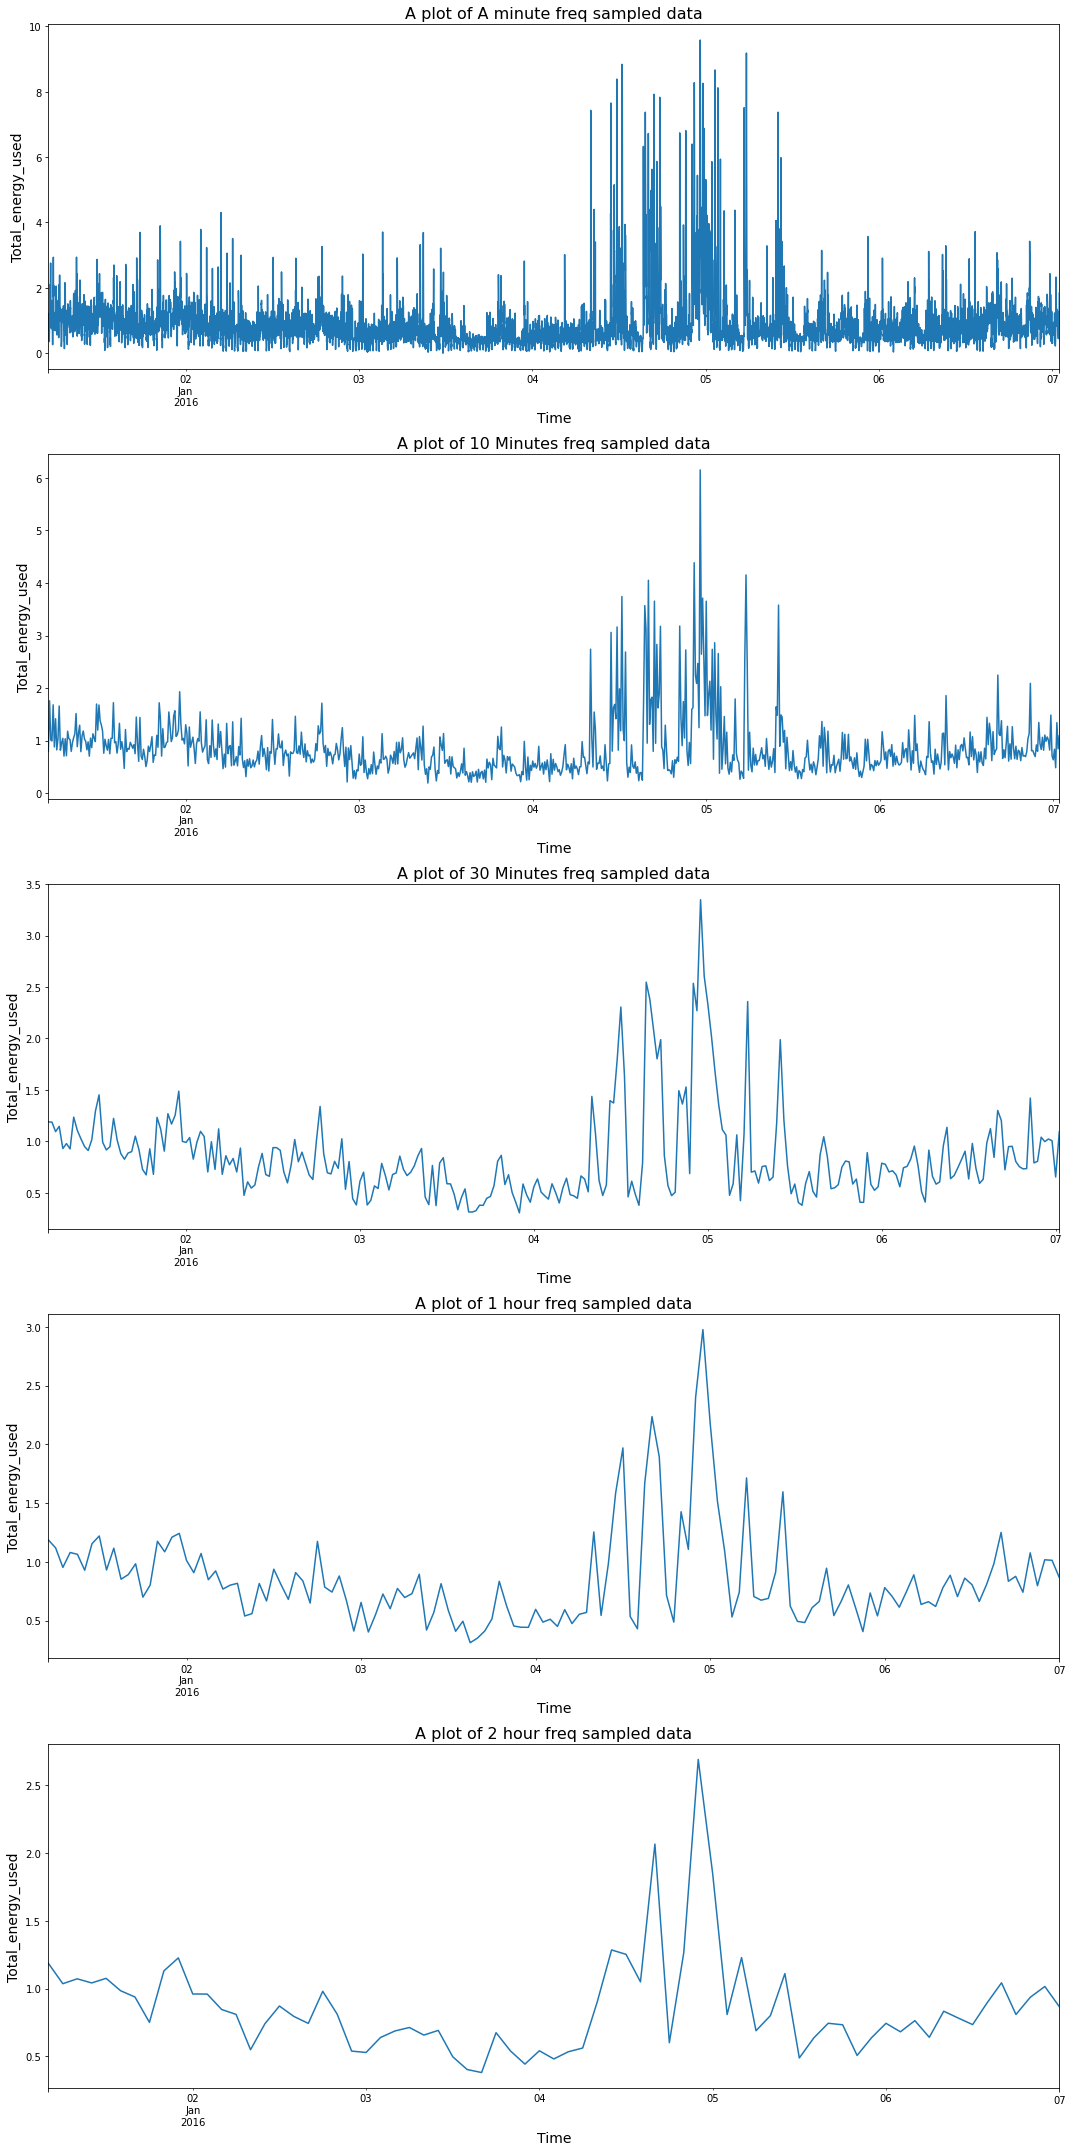

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15,30))
sample_freq_dict = {'60S':'A minute','600S':'10 Minutes','1800S':'30 Minutes','1H':'1 hour', '2H':'2 hour'}
for i, freq in enumerate(sample_freq_dict.keys()):
    sampled_data = sampler(res_df, freq)
    print('ADF Test results\n')
    adfc_test_results = test_stationarity(sampled_data, target=target, samp_data=sample_freq_dict[freq])
    sampled_data[target].plot(ax=ax[i])
    print(len(sampled_data))
    ax[i].set_title(f'A plot of {sample_freq_dict[freq]} freq sampled data', fontsize=16)
    ax[i].set_ylabel(ylabel=target.capitalize(), fontsize=14)
    ax[i].set_xlabel(xlabel='Time', fontsize=14)
    plt.savefig(f'{sample_freq_dict[freq]}_resampled.png')
    # plt.legend()
    # plt.show()
    plt.tight_layout()

In [ ]:
begin = res_df['Timestamp'][0]
end = res_df.Timestamp[-1]
diff = abs(res_df['Timestamp'][0] - res_df.Timestamp[-1])
print(f"Time from '{begin}' to '{end}' is '{diff}'")

Time from '2016-01-01 05:00:00' to '2016-01-07 00:58:29' is '5 days 19:58:29'


## Decomposition
We will now check for seasonality and trends in the data.

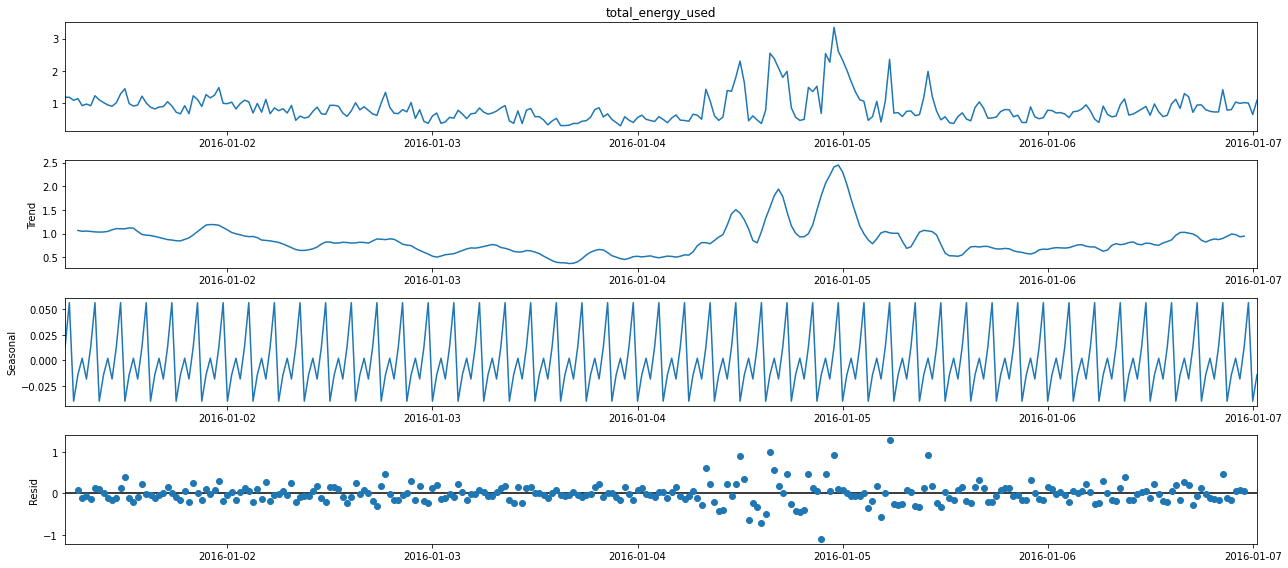

In [ ]:
decomp_df = sampler(res_df, f"{60*30}S") #30min
from pylab import rcParams
rcParams['figure.figsize'] = 18,8

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(sampled_data[target], model='additive', freq=6)

decomp.plot()
plt.tight_layout()
plt.savefig('Decomposition_plot.png')
plt.show()

# ARIMA

In [ ]:
# arima_df = df.copy()
# arima_df = sampled_data
arima_df = sampler(res_df, f"{60*30}S") #30 mins
# arima_df.index[-40:]

## Plot of ACF and PACF

Note that since we have already concluded that it is stationary, we don't need to check the differencing order of arima. It is automatically zero. Our task now is to check the p of AR and q of MA

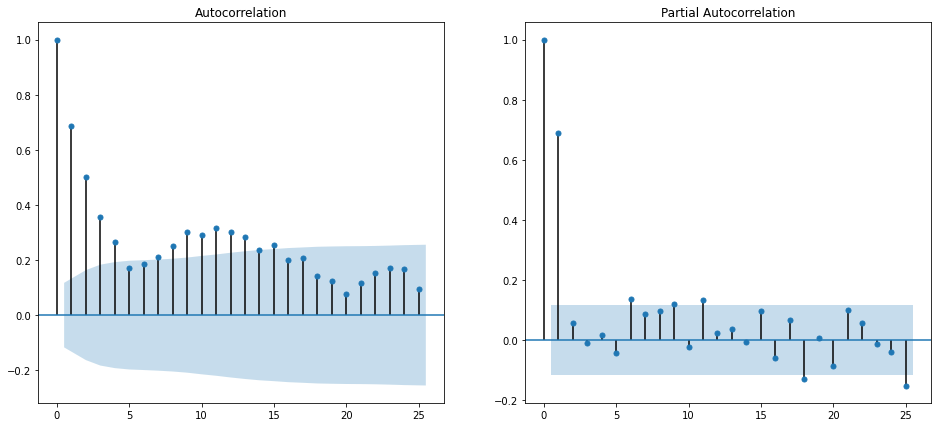

In [ ]:
# Since it is stationary d = 0
fig, ax = plt.subplots(1,2, figsize=(16,7))
# check p value of AR with pacf and q value of MA with ACF
# ax.set(ylim=(0,5))
plot_pacf(arima_df.total_energy_used, ax=ax[1])
plot_acf(arima_df.total_energy_used, ax=ax[0])
plt.savefig('ACF_PACF.png')
plt.show()

## Auto ARIMA
It is still not clear what p and q value will be from the PACF and ACF graphs above so we will use auto arima to help us in finding it

In [ ]:
auto_arima_model = pm.auto_arima(
    arima_df.total_energy_used,
    m = 6, 
    d = None,    # differencing order
    D = 0,
    max_p=3,
    max_q=3,
    trace=True,
    seasonal=True,
    error_action='ignore',
    stepwise=True,
    suppress_warnings=True,
    
)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=174.633, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=342.050, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=167.960, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=228.177, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=777.400, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=166.067, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[6] intercept   : AIC=167.972, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=170.063, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[6] intercept   : AIC=167.178, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[6] intercept   : AIC=167.205, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=230.858, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[6] intercept   : AIC=168.635, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[6]             : AIC=204.786, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[6] intercept
Total fit time: 4.508 seconds
                               SARI

## SARIMA DIAGONISTIC PLOT.
Top left plot: The residual errors fluctuate around a mean of zero.

Top right plot: The estimated density plot suggest a mean of zero and standard deviation of 1

Bottom Left: A scatter plot  with slight deviation from the red line

Bottom right: Correlogram/ACF plot.

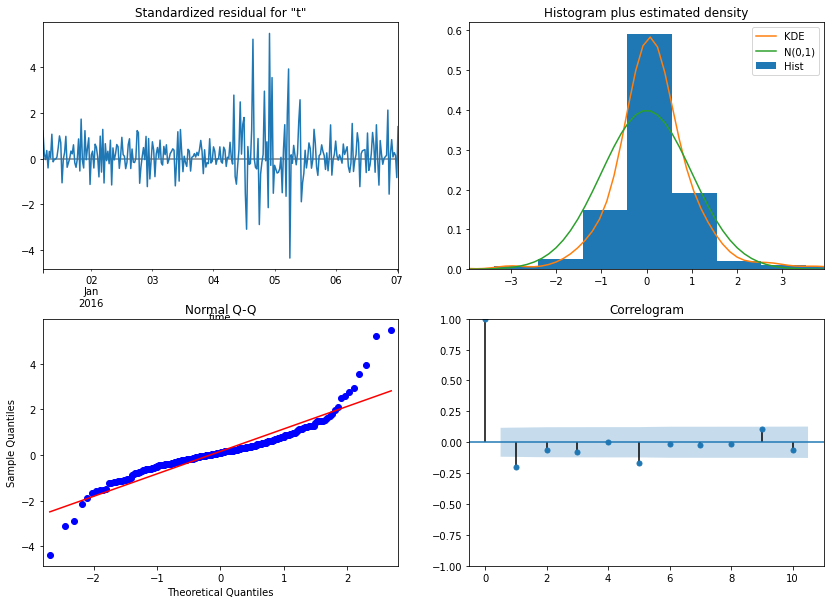

In [ ]:
# Fit model
smodel = SARIMAX(arima_df[target], 
                order=(1,0,0),
                seasonal_order=(0, 0, 0, 6))
results_1 = smodel.fit()

# Make plot of time series for comparison
results_1.plot_diagnostics(figsize=(14,10))
plt.savefig('SARIMAX_diagonistics.png')
plt.show()

In [ ]:
def main_arima(
    data,
    target,
    start_pred_from,
    order = (1, 0, 0),
    sorder = (1, 0, 0, 6), ):   

    

    # ===========================-
    # Train model
    # ===========================-
    model = SARIMAX(
        data[target],
        order = order,
        seasonal_order=sorder,
    )
    fit_stime = time.time()
    results = model.fit()
    fit_etime = time.time()
    print(f"Latency: {abs(fit_etime-fit_stime)}")


    # ===========================
    # Predict
    # ===========================
    pred_time = time.time()
    predictions = results.get_prediction(start = pd.to_datetime(start_pred_from), dynamic = False)
    pred_time = time.time()-pred_time    
    y_predictions = predictions.predicted_mean
    y_original = data[target][start_pred_from:]
    # confidence intervals
    conf_int = predictions.conf_int()
    # forecast dates
    dates = y_predictions.index
    # Calculate root_mse
    root_mse = np.sqrt(mean_squared_error(y_original, y_predictions))


    print('=====================-RESULTS:========================-')
    print(f'SARIMAX{order}x{sorder}')
    print(f'RMSE(test): {root_mse}')
    print(f'Prediction time: {pred_time} S')
    
    print(f'Prediction Horizon {abs(pd.to_datetime(start_pred_from) - data.index[-1])}')
    print('=====================================================================')


    # ===========================-
    # Plot Prediction
    # ===========================-

    fig, ax = plt.subplots(figsize=(12,7))
    # plt.figure(figsize=(12,6))
    # Plot past Appliances
    ax.plot(data[target].index, data[target], label='past')
    # Plot the prediction means as line
    ax.plot(dates, y_predictions, label='predicted')
    # Shade between the confidence intervals
    ax.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)


    # Plot legend and show figure
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Energy Consumption', fontsize=14)
    ax.set_title(f'SARIMAX{order}x{sorder}')
    plt.savefig(f'SARIMAX{order}x{sorder}_{start_pred_from}.png')
    plt.legend()
    plt.show()
    
    # Print last predicted mean
    print(y_predictions.iloc[-1])

    # Print last confidence interval
    print(conf_int.iloc[-1])
    
    return model

## Prediction plot

SARIMA (1,0,0)x(0,0,0,6)


In [ ]:
k = int(len(arima_df)*0.8)
st = arima_df.index[k]
print(st)
abs(st-arima_df.index[-1])

2016-01-05 21:00:00


Timedelta('1 days 03:30:00')

Latency: 0.037960052490234375
=====================-RESULTS:========================-
SARIMAX(1, 0, 0)x(0, 0, 0, 6)
RMSE(test): 0.25396919183446565
Prediction time: 0.001241445541381836 S
Prediction Horizon 1 days 03:30:00


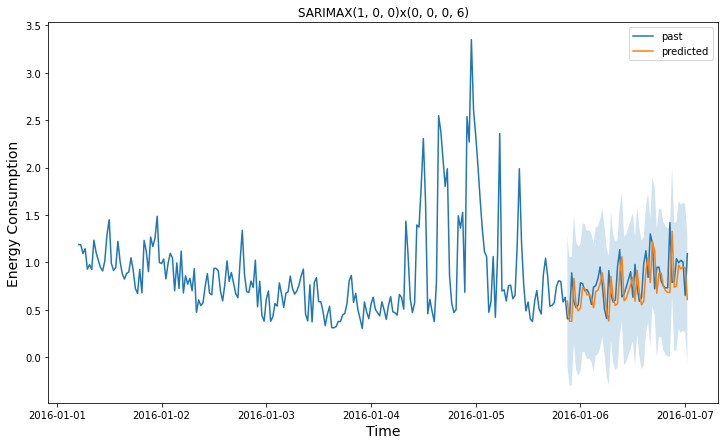

0.6107053728038039
lower total_energy_used   -0.065546
upper total_energy_used    1.286956
Name: 2016-01-07 00:30:00, dtype: float64


In [ ]:
model1 = main_arima(
    data = arima_df,
    target = target,
    start_pred_from = '2016-01-05 21:00:00',
    order = (1, 0, 0),
    sorder = (0, 0, 0, 6),
)

In [ ]:
model

SARIMA (1,0,1)x(0,0,1,6)

=====================-RESULTS:========================-
SARIMAX(1, 0, 1)x(0, 0, 1, 6)
RMSE(test): 0.2516036182521196
Prediction time: 0.0012898445129394531 S
Prediction Horizon 0 days 19:30:00


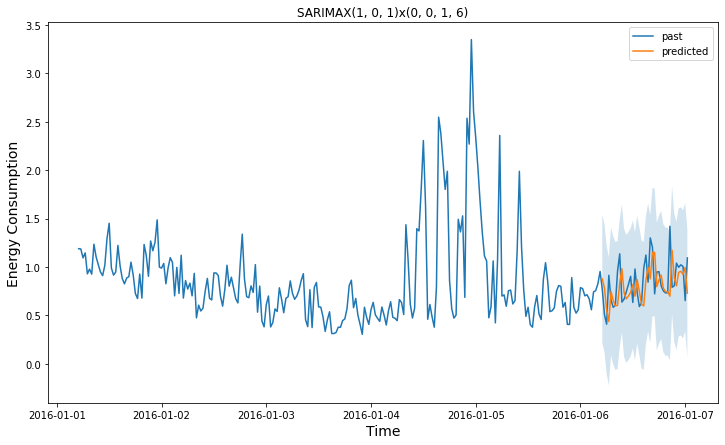

0.729661334844297
lower total_energy_used    0.068554
upper total_energy_used    1.390769
Name: 2016-01-07 00:30:00, dtype: float64


In [ ]:
model2 = main_arima(
    data = arima_df,
    target = target,
    start_pred_from = '2016-01-06 05:00:00',
    order = (1, 0, 1),
    sorder = (0, 0, 1, 6),
)

=====================-RESULTS:========================-
SARIMAX(1, 0, 0)x(0, 0, 0, 6)
RMSE(test): 0.3433843831535224
Prediction time: 0.0009372234344482422 S
Prediction Horizon 2 days 00:30:00


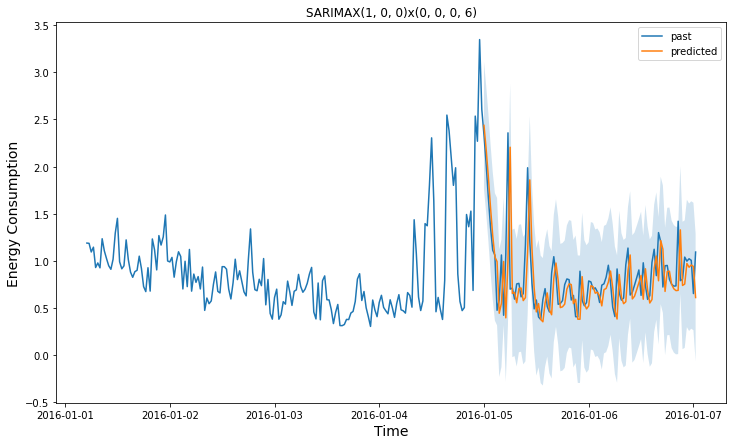

0.6107053727971746
lower total_energy_used   -0.065546
upper total_energy_used    1.286956
Name: 2016-01-07 00:30:00, dtype: float64


In [ ]:
model3 = main_arima(
    data = arima_df,
    target = target,
    start_pred_from = '2016-01-05 00:00:00',
    order = (1, 0, 0),
    sorder = (0, 0, 0, 6),
)

## Forecast: SARIMAX

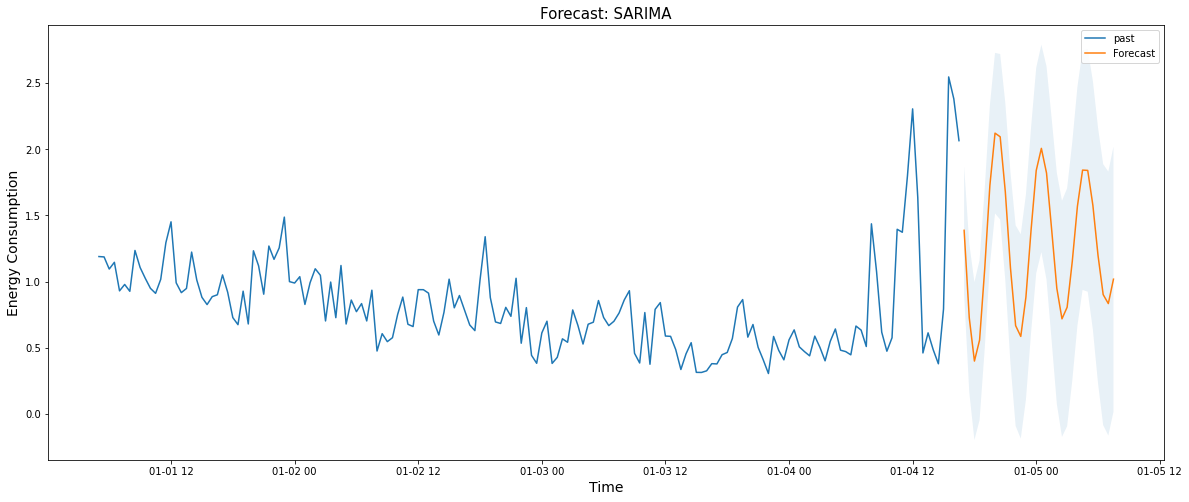

1.0175541022933037
lower total_energy_used    0.015737
upper total_energy_used    2.019372
Name: 2016-01-05 07:30:00, dtype: float64


In [ ]:
# Fit model
model = SARIMAX(arima_df[target], 
                order=(2,1,3),
                sorder=(0, 0, 0, 6))
results_2 = model.fit()

steps=30
forecast = results_2.get_forecast(steps=steps)
# predicted mean
mean = forecast.predicted_mean
# confidence intervals
conf_int = forecast.conf_int()
# forecast dates
dates = mean.index


plt.figure(figsize=(20,8))
# Plot past Appliances
plt.plot(arima_df[target].index, arima_df[target], label='past')
# Plot the prediction means as line
plt.plot(dates, mean, label='Forecast')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.1)
#lables
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.title('Forecast: SARIMA', fontsize=15)
# Plot legend and show figure
plt.legend()
plt.savefig(f'SARIMA:FORECAST{steps}.png')
plt.show()
# Print last predicted mean
print(mean.iloc[-1])

# Print last confidence interval
print(conf_int.iloc[-1])

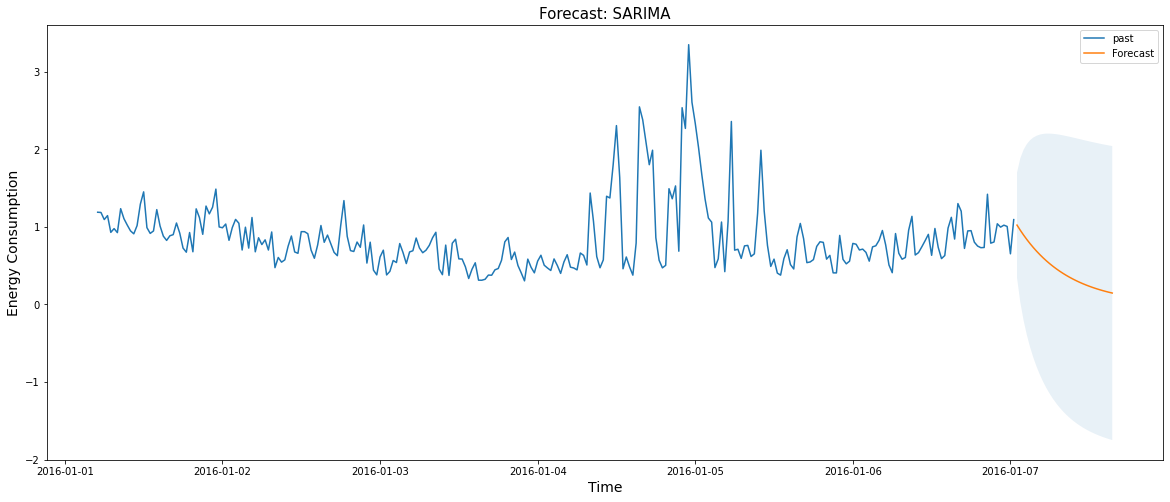

0.14720213862271694
lower total_energy_used   -1.747062
upper total_energy_used    2.041467
Name: 2016-01-07 15:30:00, dtype: float64


In [ ]:
# Fit model
model = SARIMAX(arima_df[target], 
                order=(1,0,0),
                sorder=(0, 1, 0, 12))
results_2 = model.fit()

steps=30
forecast = results_2.get_forecast(steps=steps)
# predicted mean
mean = forecast.predicted_mean
# confidence intervals
conf_int = forecast.conf_int()
# forecast dates
dates = mean.index

plt.figure(figsize=(20,8))
# Plot past Appliances
plt.plot(arima_df[target].index, arima_df[target], label='past')
# Plot the prediction means as line
plt.plot(dates, mean, label='Forecast')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.1)
#lables
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.title('Forecast: SARIMA', fontsize=15)
# Plot legend and show figure
plt.legend()
plt.savefig(f'SARIMA:FORECAST{steps}.png')
plt.show()
# Print last predicted mean
print(mean.iloc[-1])

# Print last confidence interval
print(conf_int.iloc[-1])

# Long Short-Term Memory(LSTM) Network

In [ ]:
# Load the dataset
lstm_df = df.copy().loc[:,['time', 'total_energy_used']]
lstm_df.set_index('time', inplace=True)
dataset = lstm_df.values
# dataset.head()

In [ ]:
# create the necessary functions for LSTM Network model
def timeseries_to_supervised(data, lag=1):
    dframe = pd.DataFrame(data)
    columns = [dframe.shift(i) for i in range(1, lag+1)]
    columns.append(dframe)
    dframe = pd.concat(columns, axis=1)
    dframe.fillna(0, inplace=True)
    return dframe

# def supervised_to_timeseries(data, lag=1):
#     dframe = pd.Dataframe(data)
#     co


# transform timeseries to stationary
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history([-interval])


# scale train and test data to [-1,1]
def scale(train,test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    #transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    #transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def inv_array_scale(arr, scaler):
    inv_arr = timeseries_to_supervised(arr)
    inv_arr = scaler.inverse_transform(inv_arr)
    return inv_arr


# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


def inv_array_scale(arr, scaler):
    inv_arr = timeseries_to_supervised(arr)
    inv_arr = scaler.inverse_transform(inv_arr)
    return inv_arr


# LSTM model traning and testing
def fit_lstm(train, test, batch_size, nb_epoch, neurons):
    print(f"Parameters:")
    print(f"Epoch: {nb_epoch}\nBatch size: {batch_size}\nNeurons: {neurons}")
    x_train, y_train = train[:, 0:-1], train[:, -1]
    x_test, y_test = test[:, 0:-1], test[:,-1]
    #reshape
    x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    #model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # for i in range(nb_epoch):
    start_time = time.time()
    model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size,
              verbose=0, shuffle=False)
        # model.reset_states()
    end_time = time.time()
    print(f"Latency: {abs(start_time-end_time)}S")



    mse = model.evaluate(x_test, y_test, batch_size = batch_size)
    print('Evaluation')
    print(f'Mean square error: {mse}')
    

    # predictions = model.predict(x_test)
    return model



def main_lstm(batch_size,epc,nrns, tr_ratio):
    # to stationary error
    # diff_values = difference(lstm_df.values, interval=1)
    diff_values = lstm_df.values
    # print(diff_values.head())

    # to supervised works
    supervised = timeseries_to_supervised(diff_values)

    train_size = int(len(lstm_df)*tr_ratio)
    raw_train = lstm_df.values[:train_size]
    raw_test = lstm_df.values[train_size:]
    print(f"Train Size: {abs(lstm_df.index[0]-lstm_df.index[train_size])}")
    print(f"Prediction horizon: {abs(lstm_df.index[train_size]-lstm_df.index[-1])}")



    # split into train and test sets
    train, test = supervised.values[:train_size], supervised.values[train_size:]
    # transform to scaled data
    scaler, train_scaled, test_scaled = scale(train,test)

    # fit the model
    
    lstm_model = fit_lstm(train=train_scaled,test=test_scaled, batch_size=batch_size, 
                          nb_epoch=epc, neurons=nrns)
    
    
    

    # raw_train = lstm_df.values[:train_size]
    # raw_test = lstm_df.values[train_size:]
    # print(f"Train Size: {abs(raw_train.index[0]-raw_train.index[-1])}")
    # print(f"Prediction horizon: {abs(raw_test.index[0]-raw_test.index[-1])}")

    # reshaping
    train_reshape = train_scaled[:,0].reshape(len(train_scaled),1,1)
    test_reshape = test_scaled[:,0].reshape(len(test_scaled),1,1)

    # forecast the entire training dataset
    train_pred = lstm_model.predict(train_reshape, batch_size=batch_size)
    test_pred = lstm_model.predict(test_reshape, batch_size=batch_size)
    # inverse scaling
    train_pred = inv_array_scale(train_pred,scaler)
    test_pred = inv_array_scale(test_pred,scaler)
    # inverse supervised trainsformation
    train_pred = np.array([x[1] for i, x in enumerate(train_pred) ])
    test_pred = np.array([x[1] for i,x in enumerate(test_pred)])

    print(f"RMSE: {mean_squared_error(raw_test,test_pred)}")

    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(lstm_df, label='Original')
    ax.plot(lstm_df.index, np.concatenate([train_pred,test_pred]), label='predictions')
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Energy_consumption', fontsize=14)
    ax.set_title('LSTM Network Model predictions', fontsize=15)
    plt.legend()
    plt.savefig('lstm_2.png')
    plt.show()

## LSTM plots

In [ ]:
lstm_df.head()

,total_energy_used
time,
2016-01-01 05:00:00,0.932833
2016-01-01 05:00:01,0.934333
2016-01-01 05:00:02,0.931817
2016-01-01 05:00:03,1.022050
2016-01-01 05:00:04,1.139400


In [ ]:
lstm_df.index[int(len(lstm_df)*0.747)]

Timestamp('2016-01-05 13:33:40')

In [ ]:
lstm_df.iloc[int(len(lstm_df)*0.747)]

total_energy_used    0.410133
Name: 2016-01-05 13:33:40, dtype: float64

In [ ]:
start = df.iloc[0,-1]
end = df.iloc[int(len(df)*0.514379),-1]
abs(start-end)

Timedelta('3 days 00:00:00')

Train Size: 3 days 11:59:06
Prediction horizon: 2 days 07:59:23
Parameters:
Epoch: 50
Batch size: 509
Neurons: 4
Latency: -39.673175573349S
396/396 [==============================] - 1s 1ms/step - loss: 0.0049
Evaluation
Mean square error: 0.004893213044852018
RMSE: 0.23832246007230207


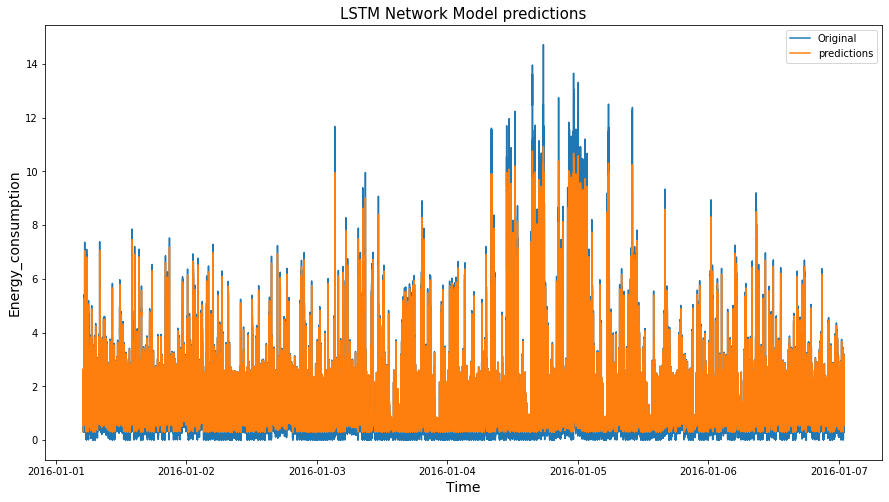

In [ ]:
main_lstm(509, 50, 4, 0.6)

Train Size: 4 days 01:58:57
Prediction horizon: 1 days 17:59:32
Parameters:
Epoch: 50
Batch size: 509
Neurons: 4
Latency: -44.97718071937561S
297/297 [==============================] - 1s 1ms/step - loss: 0.0020
Evaluation
Mean square error: 0.0020446160342544317
RMSE: 0.11067425940622236


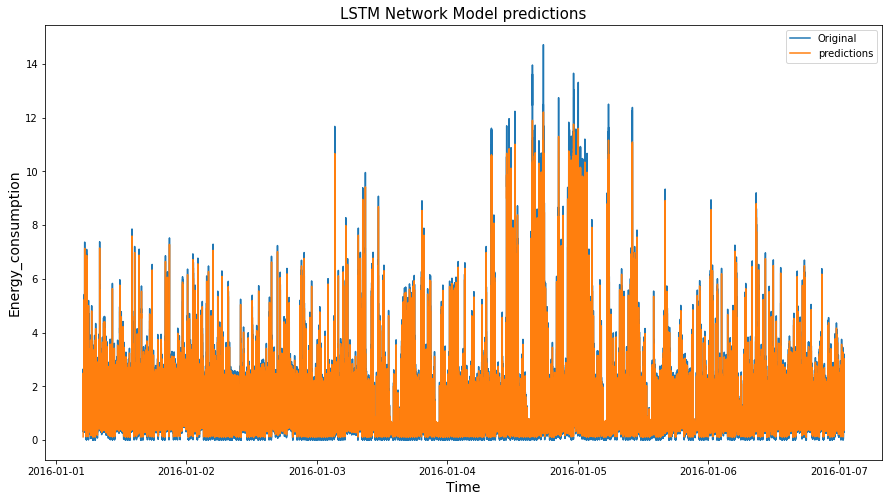

In [ ]:
main_lstm(batch_size=509, epc=50, nrns=4, tr_ratio=0.7)

Train Size: 4 days 15:58:48
Prediction horizon: 1 days 03:59:41
Parameters:
Epoch: 50
Batch size: 509
Neurons: 4
Latency: 51.72204065322876S
198/198 [==============================] - 1s 1ms/step - loss: 0.0020
Evaluation
Mean square error: 0.001972828060388565
RMSE: 0.10678844329145655


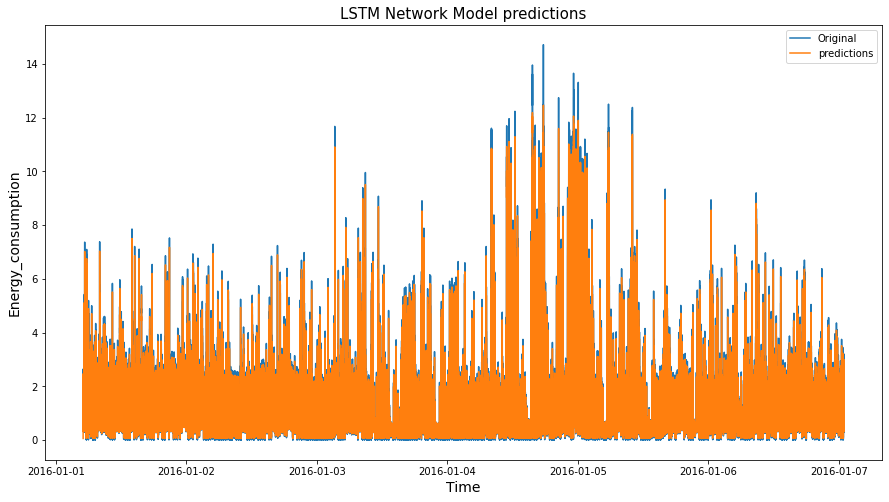

In [ ]:
main_lstm(batch_size=509, epc=50, nrns=4, tr_ratio=0.8)

# END